## Idea

The idea here is to train a classifier for positive/negative reviews over the well-known IMDB reviews database, and then use it to classify AirBnB reviews, since these are texts of similar nature. 

#### Bonus
We'll try to label with a zero-shot classification (via an LLM) a few thousands example of the AirBnB dataset to fine tune the classifier. These would not be enough examples to train from scratch a classifier (since we're limited both by time (it takes a good amount of time, and there are limits on the request per minutes we can send) and money (e.g.: Gemini's API have a free tier which is limited, otherwise you would have to pay for more requests). Nonetheless, these labeled examples might be good to fine-tune the model. 

In [ ]:
# Cell 1: Imports and GPU check
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from sklearn.model_selection import train_test_split
import re
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, accuracy_score

import warnings
warnings.filterwarnings("ignore")

print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))


TensorFlow version: 2.6.0
Num GPUs Available: 1


It is crucial that a GPU is used for this notebook, otherwise it will take a very long time to train the model (and even with a GPU such as mine (Nvidia 3060. 6 GB of dedicated RAM) is not very quick). 

## Load IMDB Dataset

This dataset was chosen since it has a good amount of data, it is labaled, and it contains reviews. Even if the topic of the review is not the same as the AirBnb one, the type of text to analyze is similar. 

In [ ]:
# Cell 2: Load dataset
df = pd.read_csv("IMDB Dataset.csv")  
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Encode labels: positive -> 1, negative -> 0
df['label'] = df['sentiment'].map({'positive': 1, 'negative': 0})

print("Total samples:", len(df))
print(df.head())


Total samples: 50000
                                              review sentiment  label
0  I really liked this Summerslam due to the look...  positive      1
1  Not many television shows appeal to quite as m...  positive      1
2  The film quickly gets to a major chase scene w...  negative      0
3  Jane Austen would definitely approve of this o...  positive      1
4  Expectations were somewhat high for me when I ...  negative      0


## TF-IDF Vectorization

In [7]:
vectorizer = TfidfVectorizer(
    ngram_range=(1, 3),   # Unigram + bigram + trigram
    analyzer='word',
    strip_accents='unicode',
    min_df=3,           # Ignore terms appearing in less than 3 reviews
    max_df=0.8          # Ignore terms appearing in more than 80% of reviews
)

# Apply TF-IDF
X = vectorizer.fit_transform(tqdm(df["review"], desc="Vectorizing with TF-IDF"))
print(f"TF-IDF matrix shape: {X.shape}")

Vectorizing with TF-IDF: 100%|██████████| 50000/50000 [00:18<00:00, 2649.31it/s]


TF-IDF matrix shape: (50000, 906033)


In [ ]:
from sklearn.model_selection import train_test_split

# Split the dataset into train, validation, and test sets
# 70% train, 15% validation, 15% test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, df["label"], test_size=0.30, random_state=42, stratify=df["label"]
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print(f"Train size: {X_train.shape[0]}")
print(f"Validation size: {X_val.shape[0]}")
print(f"Test size: {X_test.shape[0]}")


Train size: 35000
Validation size: 7500
Test size: 7500


## Simpler Model

We will try first to use some simpler and lighter model to get a baseline. To better understand their potential we will use randomized or grid searches to search the best hyperparameters of each model.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score

sgd = SGDClassifier(random_state=42)

# Hyperparameters
param_dist = {
    "loss": ["hinge", "log_loss", "modified_huber", "squared_hinge"],
    "alpha": [1e-4, 1e-5, 1e-6, 1e-3],
    "penalty": ["l2", "l1", "elasticnet"],
    "max_iter": [1000, 1500, 2000, 2500],
    "learning_rate": ["constant", "optimal", "invscaling", "adaptive"],
    "eta0": [0.001, 0.01, 0.1],
}


# Scorer: f1 macro to balance classes
scorer = make_scorer(f1_score, average='macro')

# Setup RandomizedSearch
random_search = RandomizedSearchCV(
    sgd,
    param_distributions=param_dist,
    n_iter=50,
    scoring=scorer,
    n_jobs=-1,
    cv=3,
    verbose=2,
    random_state=42,
)

# Fit
random_search.fit(X_train, y_train)


Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3, estimator=SGDClassifier(random_state=42), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'alpha': [0.0001, 1e-05, 1e-06, 0.001],
                                        'eta0': [0.001, 0.01, 0.1],
                                        'learning_rate': ['constant', 'optimal',
                                                          'invscaling',
                                                          'adaptive'],
                                        'loss': ['hinge', 'log_loss',
                                                 'modified_huber',
                                                 'squared_hinge'],
                                        'max_iter': [1000, 1500, 2000, 2500],
                                        'penalty': ['l2', 'l1', 'elasticnet']},
                   random_state=42,
                   scoring=make_scorer(f1_score, response_method='predict', average=macro),
                   verbose=2)

In [ ]:
print("Best parameters found:")
print(random_search.best_params_)

best_model = random_search.best_estimator_

# Evaluation on validation set
y_val_pred = best_model.predict(X_val)
print("\nValidation set evaluation:")
print(classification_report(y_val, y_val_pred))


Best parameters found:
{'penalty': 'l2', 'max_iter': 2000, 'loss': 'modified_huber', 'learning_rate': 'constant', 'eta0': 0.01, 'alpha': 1e-05}

Validation set evaluation:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      3750
           1       0.92      0.92      0.92      3750

    accuracy                           0.92      7500
   macro avg       0.92      0.92      0.92      7500
weighted avg       0.92      0.92      0.92      7500



In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score

log_reg = LogisticRegression(random_state=42)

# Hyperparameter distribution
param_dist = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga'],
    'penalty': ['l2'],
    'max_iter': [100, 300, 500, 1000]
}

scorer = make_scorer(f1_score, average='macro')

random_search_logreg = RandomizedSearchCV(
    log_reg,
    param_distributions=param_dist,
    n_iter=20,
    scoring=scorer,
    n_jobs=-1,
    cv=3,
    verbose=2,
    random_state=42
)

random_search_logreg.fit(X_train, y_train)


Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3, estimator=LogisticRegression(random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'C': [0.01, 0.1, 1, 10, 100],
                                        'max_iter': [100, 300, 500, 1000],
                                        'penalty': ['l2'],
                                        'solver': ['liblinear', 'saga']},
                   random_state=42,
                   scoring=make_scorer(f1_score, response_method='predict', average=macro),
                   verbose=2)

In [13]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

nb = MultinomialNB()

param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0],
    'fit_prior': [True, False]
}

scorer = make_scorer(f1_score, average='macro')

grid_search_nb = GridSearchCV(
    nb,
    param_grid=param_grid,
    scoring=scorer,
    n_jobs=-1,
    cv=3,
    verbose=2
)

grid_search_nb.fit(X_train, y_train)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


GridSearchCV(cv=3, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.001, 0.01, 0.1, 1.0, 10.0],
                         'fit_prior': [True, False]},
             scoring=make_scorer(f1_score, response_method='predict', average=macro),
             verbose=2)

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score

rf = RandomForestClassifier(random_state=42)

param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

scorer = make_scorer(f1_score, average='macro')

random_search_rf = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=30,
    scoring=scorer,
    n_jobs=-1,
    cv=3,
    verbose=2,
    random_state=42
)

random_search_rf.fit(X_train, y_train)


Fitting 3 folds for each of 30 candidates, totalling 90 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20, 30],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300]},
                   random_state=42,
                   scoring=make_scorer(f1_score, response_method='predict', average=macro),
                   verbose=2)

In [15]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Store best estimators
models = {
    "SGD Classifier": random_search.best_estimator_,
    "Logistic Regression": random_search_logreg.best_estimator_,
    "Naive Bayes": grid_search_nb.best_estimator_,
    "Random Forest": random_search_rf.best_estimator_
}

# Evaluate each model
for name, model in models.items():
    y_pred = model.predict(X_test)
    
    print(f"🔹 {name}")
    print(f"Accuracy       : {accuracy_score(y_test, y_pred):.4f}")
    print(f"F1 (macro)     : {f1_score(y_test, y_pred, average='macro'):.4f}")
    print(f"Precision (macro): {precision_score(y_test, y_pred, average='macro'):.4f}")
    print(f"Recall (macro) : {recall_score(y_test, y_pred, average='macro'):.4f}")
    print("-" * 40)


🔹 SGD Classifier
Accuracy       : 0.9167
F1 (macro)     : 0.9167
Precision (macro): 0.9167
Recall (macro) : 0.9167
----------------------------------------
🔹 Logistic Regression
Accuracy       : 0.9159
F1 (macro)     : 0.9159
Precision (macro): 0.9159
Recall (macro) : 0.9159
----------------------------------------
🔹 Naive Bayes
Accuracy       : 0.9012
F1 (macro)     : 0.9012
Precision (macro): 0.9012
Recall (macro) : 0.9012
----------------------------------------
🔹 Random Forest
Accuracy       : 0.8647
F1 (macro)     : 0.8646
Precision (macro): 0.8649
Recall (macro) : 0.8647
----------------------------------------


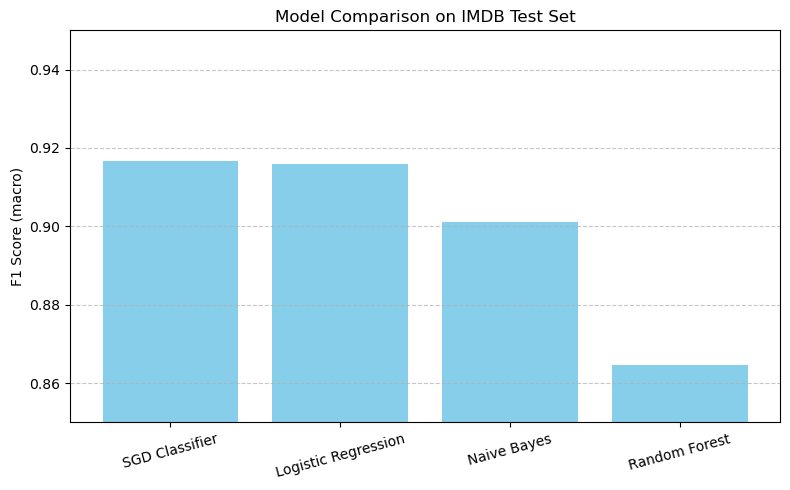

In [ ]:
import matplotlib.pyplot as plt

f1_scores = {
    name: f1_score(y_test, model.predict(X_test), average='macro')
    for name, model in models.items()
}

plt.figure(figsize=(8, 5))
plt.bar(f1_scores.keys(), f1_scores.values(), color='skyblue')
plt.ylabel("F1 Score (macro)")
plt.title("Model Comparison on IMDB Test Set")
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.ylim(0.85, 0.95)

plt.tight_layout()
plt.show()


## Tokenization of IMDB dataset

Since we will use a DistilBERT model, ("original" BERT is way too heacy for my machine), we will use its own tokenizer accordingly. 

In [ ]:
# Cell 3: Tokenization parameters (Updated for DistilBERT)

from transformers import DistilBertTokenizer
import tensorflow as tf
import pandas as pd

print("Loading DistilBERT tokenizer...")
# Use the tokenizer corresponding to the DistilBERT model
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# Function to encode the reviews using the DistilBERT tokenizer
def encode_reviews(reviews):
    print(f"Encoding reviews with max_length={MAX_LEN}...")
    encoded_batch = tokenizer(
        reviews.tolist(),             # Input text reviews as a list
        add_special_tokens=True,      # Add [CLS] and [SEP] tokens
        max_length=MAX_LEN,           # Pad or truncate sequences to MAX_LEN
        padding='max_length',         # Pad shorter sequences to MAX_LEN
        truncation=True,              # Truncate longer sequences to MAX_LEN
        return_tensors='tf'           # Return TensorFlow tensors
    )
    print("Encoding complete.")
    return encoded_batch

if 'review' not in df.columns or 'label' not in df.columns:
     raise ValueError("DataFrame must contain 'review' and 'label' columns.")

encoded_reviews = encode_reviews(df['review'])

input_ids = encoded_reviews['input_ids']
attention_masks = encoded_reviews['attention_mask']

labels = tf.convert_to_tensor(df['label'].values, dtype=tf.int32) # Ensure labels are integers

print("\nShape of input_ids:", input_ids.shape)
print("Shape of attention_masks:", attention_masks.shape)
print("Shape of labels:", labels.shape)
# Example output (first 5 tokens of the first review)
print("\nExample input_ids (first review, first 10 tokens):", input_ids[0, :10].numpy())
print("Example attention_mask (first review, first 10 tokens):", attention_masks[0, :10].numpy())

Loading DistilBERT tokenizer...
Encoding reviews with max_length=256...
Encoding complete.

Shape of input_ids: (50000, 256)
Shape of attention_masks: (50000, 256)
Shape of labels: (50000,)

Example input_ids (first review, first 10 tokens): [  101  1045  2428  4669  2023 10945 10278  2349  2000  1996]
Example attention_mask (first review, first 10 tokens): [1 1 1 1 1 1 1 1 1 1]


### Splitting the dataset

It is important to spilt the dataset in training, validation and testing to properly train our model

In [4]:
# Cell 4: Train/Validation/Test Split (using NumPy + sklearn)

import numpy as np
from sklearn.model_selection import train_test_split

print("\nSplitting data into training, validation, and test sets...")

# Convert tf.Tensors to numpy arrays for sklearn compatibility
input_ids_np   = input_ids.numpy()       # shape: (50000, MAX_LEN)
attention_np   = attention_masks.numpy() # shape: (50000, MAX_LEN)
labels_np      = labels.numpy()          # shape: (50000,)

# 1) Split into train (70%) and temp (30%)
X_train_ids, X_temp_ids, \
X_train_mask, X_temp_mask, \
y_train, y_temp = train_test_split(
    input_ids_np,
    attention_np,
    labels_np,
    test_size=0.30,
    random_state=42,
    stratify=labels_np
)

# 2) Split temp equally into validation (15%) and test (15%)
X_val_ids, X_test_ids, \
X_val_mask, X_test_mask, \
y_val, y_test = train_test_split(
    X_temp_ids,
    X_temp_mask,
    y_temp,
    test_size=0.50,
    random_state=42,
    stratify=y_temp
)

# Print out the number of samples in each set
print(f"Training samples:    {X_train_ids.shape[0]}")   # ~35000
print(f"Validation samples:  {X_val_ids.shape[0]}")     # ~7500
print(f"Test samples:        {X_test_ids.shape[0]}")    # ~7500



Splitting data into training, validation, and test sets...
Training samples:    35000
Validation samples:  7500
Test samples:        7500


## DistilBERT + BiLSTM model

Now we define the model. We will use as "core" of the model distilBERT. We will add after this a RNN (Recurrent Neural Network) with LSTM (Long Short Term Memory). These kind of NN are ideal to work with sequence of data. In our case, the sequence is represented by the words (or tokens, after the tokenization) of our reviews. Finally, we will have a classic dense layer and in the final layer just one neuron with a sigmoid, that performs the final binary classification. 

The final model is pretty big, and will have a total of 66,797,697 trainable paramters. In fact, we will not froze distilBERT parameters, for the moment, since the learning is much lower and slower if we do so (we tried and it was not great. Shorter training times, but a very limited model). 

In [4]:
# Cell 5: Build the DistilBERT + BiLSTM model (Updated)

import tensorflow as tf
from transformers import TFDistilBertModel # <--- Changed from TFBertModel

# Define constants
MAX_LEN = 256
BATCH_SIZE = 16

def create_distilbert_model(max_len=MAX_LEN, lstm_units=64, dense_units=64, dropout_rate=0.3):
    
    # --- Input Layers ---
    input_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    attention_mask = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

    # --- Pre-trained DistilBERT ---
    print("Loading pre-trained DistilBERT model...")
    # Load the DistilBERT base uncased model
    try:
      distilbert = TFDistilBertModel.from_pretrained("distilbert-base-uncased")
    except Exception as e:
      print(f"Error loading DistilBERT model: {e}")
      raise

    # Set DistilBERT layers to be non-trainable (feature extraction) or trainable (fine-tuning)
    # distilbert.trainable = False # Uncomment for faster training, fewer parameters to update
    distilbert.trainable = True   # Set to True for fine-tuning the DistilBERT layers

    # Get the last hidden states from DistilBERT
    # Output shape: (batch_size, sequence_length, hidden_size=768)
    distilbert_output = distilbert(input_ids=input_ids, attention_mask=attention_mask)[0]
    print("DistilBERT model loaded.")

    # --- BiLSTM Layer ---
    # Apply Bidirectional LSTM on the sequence output of DistilBERT
    # return_sequences=False because the next layer is Dense (we only need the final output)
    print("Adding BiLSTM layer...")
    lstm_layer = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(lstm_units, return_sequences=False),
        name="bidirectional_lstm"
    )(distilbert_output)
    # Apply Dropout for regularization
    lstm_dropout = tf.keras.layers.Dropout(dropout_rate, name="lstm_dropout")(lstm_layer)

    # --- Dense Layers ---
    print("Adding Dense layers...")
    # Intermediate Dense layer
    dense_layer = tf.keras.layers.Dense(dense_units, activation='relu', name="dense_intermediate")(lstm_dropout)
    dense_dropout = tf.keras.layers.Dropout(dropout_rate, name="dense_dropout")(dense_layer)

    # --- Output Layer ---
    # Final Dense layer for binary classification (1 unit, sigmoid activation)
    output = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(dense_dropout)

    # --- Build the Keras Model ---
    model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output, name="DistilBERT_BiLSTM_Classifier")
    print("Model created successfully.")
    return model

# Create the model instance
distilbert_model = create_distilbert_model()

# Display the model summary
print("\nModel Summary:")
distilbert_model.summary()

# --- Compilation Example (remember to compile before training) ---
# optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5) # Example learning rate for fine-tuning
# loss = tf.keras.losses.BinaryCrossentropy()
# metrics = [tf.keras.metrics.BinaryAccuracy(name='accuracy')]
# distilbert_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
# print("\nModel compiled and ready for training.")

Loading pre-trained DistilBERT model...


DistilBERT model loaded.
Adding BiLSTM layer...
Adding Dense layers...
Model created successfully.

Model Summary:
Model: "DistilBERT_BiLSTM_Classifier"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 256)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 256)]        0                                            
__________________________________________________________________________________________________
tf_distil_bert_model (TFDistilB TFBaseModelOutput(la 66362880    input_ids[0][0]                  
                                                                 attention_mask[0][0]             
_______________________________________________________

In [6]:
# Cell 6: Compile & train
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
distilbert_model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True,
    verbose=1
)

history = distilbert_model.fit(
    x={'input_ids': X_train_ids, 'attention_mask': X_train_mask},
    y=y_train,
    validation_data=(
        {'input_ids': X_val_ids, 'attention_mask': X_val_mask},
        y_val
    ),
    epochs=20,
    batch_size=8,
    callbacks=[early_stopping]
)


Epoch 1/10
4375/4375 [==============================] - 733s 167ms/step - loss: 0.2932 - accuracy: 0.8779 - val_loss: 0.2220 - val_accuracy: 0.9059
Epoch 2/10
4375/4375 [==============================] - 727s 166ms/step - loss: 0.1772 - accuracy: 0.9351 - val_loss: 0.2113 - val_accuracy: 0.9189
Epoch 3/10
4375/4375 [==============================] - 728s 166ms/step - loss: 0.1001 - accuracy: 0.9661 - val_loss: 0.2421 - val_accuracy: 0.9127
Epoch 4/10
4375/4375 [==============================] - 728s 166ms/step - loss: 0.0596 - accuracy: 0.9812 - val_loss: 0.2864 - val_accuracy: 0.9153
Restoring model weights from the end of the best epoch.
Epoch 00004: early stopping


In [8]:
# Cell 7: Evaluate on test data
results = distilbert_model.evaluate(
    x={'input_ids': X_test_ids, 'attention_mask': X_test_mask},
    y=y_test
)
print(f"Test Loss: {results[0]:.4f}")
print(f"Test Accuracy: {results[1]*100:.2f}%")


235/235 [==============================] - 38s 162ms/step - loss: 0.2058 - accuracy: 0.9180
Test Loss: 0.2058
Test Accuracy: 91.80%


In [9]:
# --- Save the trained model ---
print("\nSaving the trained model...")
# Define the path and filename for the saved model (using the recommended .keras format)
model_save_path = 'distilbert_bilstm_imdb_classifier.keras'

try:
    # Save the entire model (architecture, weights, optimizer state)
    distilbert_model.save(model_save_path)
    print(f"Model saved successfully to: {model_save_path}")
except Exception as e:
    print(f"Error saving model: {e}")


Saving the trained model...
Model saved successfully to: distilbert_bilstm_imdb_classifier.keras


In [1]:
import tensorflow as tf
from transformers import TFDistilBertModel
from transformers import DistilBertTokenizer

print("Loading the saved model...")
model_load_path = 'distilbert_bilstm_imdb_classifier.keras' 

try:
    # Load the model, providing the custom layer class definition
    loaded_model = tf.keras.models.load_model(
        model_load_path,
        custom_objects={'TFDistilBertModel': TFDistilBertModel} 
    )

    print("Model loaded successfully using custom_objects.")
    # Verify the model structure
    loaded_model.summary()

except FileNotFoundError:
     print(f"Error: Model file not found at {model_load_path}")
except Exception as e:
    print(f"Error loading model: {e}")

Loading the saved model...
Model loaded successfully using custom_objects.
Model: "DistilBERT_BiLSTM_Classifier"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 256)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 256)]        0                                            
__________________________________________________________________________________________________
tf_distil_bert_model (TFDistilB TFBaseModelOutput(la 66362880    input_ids[0][0]                  
                                                                 attention_mask[0][0]             
_______________________________________________________________________________________________

# AirBnb Dataset

Now we load the AirBnB dataset, and we prepare the data for the zero-shot classification. As per request of the assignment, we will only focus on english reviews. To do so, we will use the 'langdetect' library to recognize the language of each review, and keep only the english one. This part of the task is done with 'pandarallel', so it can be carried out using multiple threads, to reduce total execution time. 

In [ ]:
# --- 1. Load Dataset ---
csv_file = "reviews.csv"
try:
    df = pd.read_csv(csv_file)
    if 'comments' not in df.columns:
        raise ValueError(f"Unexpected format of dataset '{csv_file}'.")
    # Handle any missing values in the comments column (replace with empty string)
    df['comments'] = df['comments'].fillna('')
    print(f"Loaded {len(df)} reviews from '{csv_file}'.")
    print(df.head())
except FileNotFoundError:
    raise FileNotFoundError(f"Dataset file '{csv_file}' not found")
except Exception as e:
    raise ValueError(f"Dataset file '{csv_file}' is empty")

# --- 1.1 Extract subset of dataset ---

# Small data-viz
print("\n--- First 5 rows: ---")
print(df.head())

print("\n---DataFrame info: ---")
df.info()

# check dataset "health"
print("\n--- Missing values for each column: ---")
print(df.isnull().sum())

# missing reviews (if any)
missing_comments = df['comments'].isnull().sum()
print(f"\nNumber of missing reviews: {missing_comments}")

# I'll remove eventual rows with missing reviews becuase they're useless
if missing_comments > 0:
    df.dropna(subset=['comments'], inplace=True)
    print(f"\nRemoved {missing_comments} rows.")
    print(f"Number of actual reviews: {len(df)}")

Loaded 144948 reviews from 'reviews.csv'.
   listing_id      id        date  reviewer_id reviewer_name  \
0      164448  407660  2011-07-30       870312          Fred   
1      164448  451097  2011-08-16       901633        Julien   
2      164448  472271  2011-08-24       894674       Liliana   
3      164448  521708  2011-09-11       232485          Ravi   
4      164448  568347  2011-09-26       896712          Ruud   

                                            comments  
0  great fun at lidia's. she had the power adapte...  
1  Great centrally located room, very nice facili...  
2  Lidia is a very nice person. Very good plase t...  
3  Great host, although we were late in our arriv...  
4  Good location (for us), the bed was good and t...  

--- First 5 rows: ---
   listing_id      id        date  reviewer_id reviewer_name  \
0      164448  407660  2011-07-30       870312          Fred   
1      164448  451097  2011-08-16       901633        Julien   
2      164448  472271  2011-

In [15]:
# Import and initialize pandarallel
import pandas as pd
from pandarallel import pandarallel
import langdetect
from langdetect import DetectorFactory, LangDetectException

DetectorFactory.seed = 0

pandarallel.initialize(progress_bar=True)

# --- Function to detect the language of a text ---
def detect_language(text):
    """
    Detects the language of a given text string.
    Handles potential errors during detection.
    Imports are placed inside for parallel processing compatibility.
    """
    # --- Imports moved inside the function ---
    import langdetect
    from langdetect import LangDetectException
    # -----------------------------------------
    try:
        # Ensure input is a string, return 'not_a_string' otherwise
        if not isinstance(text, str):
            return 'not_a_string'
        # Detect language using langdetect library
        return langdetect.detect(text)
    except LangDetectException:
        # Handle errors for short/empty/problematic text (e.g., numbers only)
        # Return 'unknown' if language cannot be detected
        return 'unknown'
    except Exception as e:
        # Handle other unexpected errors during detection
        print(f"Unexpected error detecting language for: {text[:50]}... Error: {e}")
        return 'error'

# Apply the function *in parallel* to the 'comments' column
print("\nDetecting language for each comment (using parallel processing)...")
df['language'] = df['comments'].astype(str).parallel_apply(detect_language)
print("Language detection complete.")

# Display the distribution of detected languages
print("\n--- Distribution of detected languages: ---")
print(df['language'].value_counts())

# Filter the DataFrame to keep only English ('en') reviews
original_count = len(df)
# Create a copy to avoid SettingWithCopyWarning when modifying later
df_english = df[df['language'] == 'en'].copy()

# Remove the 'language' column after filtering as it will not be needed anymore
# Note: inplace=True modifies df_english directly
df_english.drop(columns=['language'], inplace=True)

# Show how many English reviews were found compared to the total
english_count = len(df_english)
if original_count > 0:
    print(f"\nTotal reviews before language filtering: {original_count}")
    print(f"Number of reviews identified as English: {english_count}")
    print(f"Percentage of English reviews: {english_count / original_count:.2%}")
else:
    print("\nDataFrame was empty before language filtering.")


INFO: Pandarallel will run on 14 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/

Detecting language for each comment (using parallel processing)...


Language detection complete.

--- Distribution of detected languages: ---
language
en         99696
fr         10798
de          9806
sv          7281
es          3028
it          2062
nl          1952
no          1904
da          1706
zh-cn        751
fi           571
unknown      550
ko           532
ru           510
pt           499
pl           422
ro           389
ca           346
tr           262
cs           229
af           225
so           223
ja           203
el           124
hu           118
id            93
zh-tw         93
tl            84
cy            79
sk            62
uk            61
hr            53
sw            39
he            31
et            29
lt            27
lv            25
vi            20
sl            19
bg            17
ar            14
th             6
sq             4
mk             4
ur             1
Name: count, dtype: int64

Total reviews before language filtering: 144948
Number of reviews identified as English: 99696
Percentage of English reviews:

In [16]:
# Save english review in a separate file, as a backup (and to speed up debugging)
output_file = 'reviews_eng.csv'
print(df_english.columns.tolist())


print(f"\nSaving the filtered English reviews to '{output_file}'...")

# Save the df_english DataFrame to a CSV file
# index=False prevents pandas from writing the DataFrame index as a column
# encoding='utf-8' is recommended for compatibility with text data
try:
    df_english.to_csv(output_file, index=False, encoding='utf-8')
    print(f"Successfully saved {len(df_english)} English reviews to '{output_file}'.")
except Exception as e:
    print(f"Error saving file: {e}")

['listing_id', 'id', 'date', 'reviewer_id', 'reviewer_name', 'comments']

Saving the filtered English reviews to 'reviews_eng.csv'...
Successfully saved 99696 English reviews to 'reviews_eng.csv'.


## Zero-Shot Classification: Gemini

To do the zero shot classification of a (limited) subset of our data, we will use the free-tier of Gemini's API. We will use an older model (Gemini 1.5 flash), since we have less constraint when using the free tier of API. It should be able to classify correctly the reviews anyways, being a LLM that has a very good understanding of the Natural Language. 

In [ ]:
# -*- coding: utf-8 -*-
from dotenv import load_dotenv
import os
import pandas as pd
import google.generativeai as genai
import time
from tqdm.notebook import tqdm  

load_dotenv()

GOOGLE_API_KEY=os.getenv("API_KEY")
if not GOOGLE_API_KEY:
    raise RuntimeError("Missing API_KEY in environment. Please add it to your .env")


genai.configure(api_key=GOOGLE_API_KEY)

if 'df_english' not in globals():
    df_english = pd.read_csv("reviews_eng.csv")
    csv_file = "reviews.csv"
    print(f"\nDataset successfuly loaded from memory.")


df_labelled = df_english.sample(n=1000, random_state=1)  # 1000 random elems from df. This will be used to fine tune the model 

# drop those elemets from the original df
df_english = df_english.drop(df_labelled.index).reset_index(drop=True)
df_labelled = df_labelled.reset_index(drop=True)

print(f"Created df_labelled with {len(df_labelled)} reviews from '{csv_file}'.")
print(df_labelled.head())


# --- 3. Init Gemini ---
model = genai.GenerativeModel('gemini-1.5-flash') # older but better limits for the free tier
assert model is not None
print(f"Gemini model '{model.model_name}' initialized.")

# --- 4. Label review ---
def classify_review_sentiment(review_text):
    """
    Send a review of AirBnb dataset to Gemini. It will return '1' for positive review, '0' for negative. 'None' if something is unespected. 
    """
    if not isinstance(review_text, str) or not review_text.strip():
        return None, "Review was not formatted correctly"

    # Prompt 
    prompt = f"""
    Analyze the sentiment of the following Airbnb review.
    Is the review positive or negative?
    Respond EXCLUSIVELY with '1' if the review is positive.
    Respond EXCLUSIVELY with '0' if the review is negative.
    Do not include any explanations, additional text, or other characters. Only '1' or '0'.

    Review:
    "{review_text}"

    Response (only 1 or 0):"""

    try:
        generation_config = genai.types.GenerationConfig(
            candidate_count=1, # only one answer
            temperature=0.1, # lower temp = less creative. We only want 0/1 answers, so low creativity
             max_output_tokens=5 # Limit answers' lenght (just in case)
        )

        response = model.generate_content(
            prompt,
            generation_config=generation_config,
            )

        # Parsing answer
        cleaned_response = response.text.strip()

        if cleaned_response == '1':
            return 1, "ok"
        elif cleaned_response == '0':
            return 0, "ok"
        else:
            # Unexpected repsonse
            print(f"\nWarning: Unexpected response for review: '{review_text[:60]}...': '{response.text}'. Label will be 'None'.", flush=True)
            print(f"Feedback prompt: {response.prompt_feedback}", flush=True)
            reason_msg = f"Exception during API call: {type(e).__name__}: {e}"
            return None, reason_msg

    except Exception as e:
        return None, "EXCEPTION: " + e.with_traceback

    finally:
        # Sleep to be compliant with free-tier API rates
        time.sleep(4.1)

# --- 5. Apply the Function to the DataFrame ---
tqdm.pandas(desc="Labelling reviews")

print("\n--- LABELLING DATASET SUBSET ---")

labels = []

for idx, review in enumerate(tqdm(df_labelled['comments'], total=len(df_labelled))):
    label, reason = classify_review_sentiment(review)
    
    if label is None:
        print(f"[ROW {idx}] Label is None for review[:100]: {review[:100]!r}", flush=True)
        print(f"Error/Reason is: {reason}", flush=True)
    
    labels.append(label)

df_labelled['sentiment_label'] = labels

print("\n--- DONE! ---")

# --- 6. Labelling visualization ---

# Show some reviews and their labels
print("\nExamples of labelled reviews:")
print(df_labelled[['comments', 'sentiment_label']].head(10))

# Count how many reviews were classified as positive, negative, or had errors (None)
print("\nLabels count:")
print(df_labelled['sentiment_label'].value_counts(dropna=False)) # dropna=False includes None counts

# Show examples of reviews that caused errors (if any)
errors = df_labelled[df_labelled['sentiment_label'].isna()]
if not errors.empty:
    print(f"\n{len(errors)} reviews were not classified correctly (label None). Examples:")
    print(errors[['comments']].head())

# --- 7. Save (Optional) ---
# Save the DataFrame with the new column to a new CSV file
output_filename = "reviews_labelled_gemini.csv"
df_labelled.to_csv(output_filename, index=False, encoding='utf-8')
print(f"\nDataFrame saved in '{output_filename}'.")


Created df_labelled with 1000 reviews from 'reviews.csv'.
            listing_id                   id        date  reviewer_id  \
0              7452173             83955523  2016-07-04     15340719   
1   820745358588537821   915062176998968649  2023-06-16    122233215   
2   826201900527590906  1122374106482196092  2024-03-28    160169071   
3  1089847010707927485  1180360314242415307  2024-06-16     21888322   
4             36723848            594731286  2020-01-19    112579274   

  reviewer_name                                           comments  
0         Brian  Excellent penthouse apartment in a great locat...  
1     Guillaume  Would recommend! Very friendly host and and re...  
2         Laura  Great one bedroom apartment. Very clean and ta...  
3      Viktoria  Well equipped, sunny and nicely designed apart...  
4          Rémy  Spacious and clean place.<br/>We really apprec...  
Gemini model 'models/gemini-1.5-flash' initialized.

--- LABELLING DATASET SUBSET ---


  0%|          | 0/1000 [00:00<?, ?it/s]


--- DONE! ---

Examples of labelled reviews:
                                            comments  sentiment_label
0  Excellent penthouse apartment in a great locat...                1
1  Would recommend! Very friendly host and and re...                1
2  Great one bedroom apartment. Very clean and ta...                1
3  Well equipped, sunny and nicely designed apart...                1
4  Spacious and clean place.<br/>We really apprec...                1
5  Such an ideal Airbnb<br/>Went as a group of fo...                1
6  Clean and cozy. Good value for the price we pa...                1
7  I prefer an apartment with kitchen (or at leas...                1
8  Awesome place , great location she was very he...                1
9  forenom was a nice place to stay. sort of a cr...                1

Labels count:
sentiment_label
1    964
0     36
Name: count, dtype: int64

DataFrame saved in 'reviews_labelled_gemini.csv'.


## Fine Tuning on Labelled AirBnb (sub)dataset

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import DistilBertTokenizer, TFDistilBertModel
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

print("Libraries imported successfully.")

Libraries imported successfully.


In [5]:
MAX_LEN = 256
BATCH_SIZE = 16 

# Load the DistilBERT tokenizer
print("Loading DistilBERT tokenizer...")
try:
    tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
    print("Tokenizer loaded successfully.")
except Exception as e:
    print(f"Error loading tokenizer: {e}")
    raise

# Function to encode reviews
def encode_reviews(reviews, max_len=MAX_LEN):
    """
    Tokenizes a list of reviews using the loaded DistilBERT tokenizer.
    Adds special tokens, pads/truncates to max_len, and returns TensorFlow tensors.
    """
    print(f"Encoding reviews with max_length={max_len}...")
    # Convert reviews to list if it's a pandas Series
    if isinstance(reviews, pd.Series):
        reviews_list = reviews.tolist()
    else:
        reviews_list = reviews

    # Ensure all elements are strings and handle potential non-string types
    reviews_list = [str(review) if pd.notna(review) else "" for review in reviews_list]

    encoded_batch = tokenizer(
        reviews_list,                 # Input text reviews as a list
        add_special_tokens=True,      # Add [CLS] and [SEP] tokens
        max_length=max_len,           # Pad or truncate sequences to max_len
        padding='max_length',         # Pad shorter sequences to max_len
        truncation=True,              # Truncate longer sequences to max_len
        return_tensors='tf'           # Return TensorFlow tensors
    )
    print("Encoding complete.")
    return encoded_batch

Loading DistilBERT tokenizer...


Tokenizer loaded successfully.


In [6]:
# --- 1. Load the Gemini-labeled dataset ---
gemini_labeled_file = "reviews_labelled_gemini.csv"
print(f"Loading Gemini-labeled data from: {gemini_labeled_file}")
try:
    df_gemini = pd.read_csv(gemini_labeled_file)
    print(f"Successfully loaded {len(df_gemini)} rows.")
except FileNotFoundError:
    print(f"Error: File not found at {gemini_labeled_file}")
    raise
except Exception as e:
    print(f"An error occurred while loading {gemini_labeled_file}: {e}")
    raise

# --- 2. Preprocess the data ---
# Rename columns for consistency
if 'comments' in df_gemini.columns and 'sentiment_label' in df_gemini.columns:
    df_gemini = df_gemini.rename(columns={'comments': 'review', 'sentiment_label': 'label'})
    print("Renamed columns 'comments'->'review' and 'sentiment_label'->'label'.")
else:
     print("Warning: Expected columns 'comments' and 'sentiment_label' not found. Assuming 'review' and 'label' already exist.")
     if 'review' not in df_gemini.columns or 'label' not in df_gemini.columns:
         raise ValueError("DataFrame must contain review and label columns (expected 'comments'/'sentiment_label' or 'review'/'label')")

# Keep only rows with valid labels (0 or 1)
initial_count = len(df_gemini)
df_gemini.dropna(subset=['label'], inplace=True) # Remove rows where label is NaN/None
df_gemini = df_gemini[df_gemini['label'].isin([0, 1])] # Keep only 0s and 1s
df_gemini['label'] = df_gemini['label'].astype(int) # Ensure labels are integers
final_count = len(df_gemini)
print(f"Filtered data: Removed {initial_count - final_count} rows with invalid labels. Kept {final_count} rows.")

# Check for empty reviews after filtering
df_gemini.dropna(subset=['review'], inplace=True)
df_gemini = df_gemini[df_gemini['review'].str.strip().astype(bool)] # Remove empty or whitespace-only reviews
print(f"Removed empty reviews. Final count for fine-tuning: {len(df_gemini)}")

# Display info and head
print("\nGemini DataFrame info after preprocessing:")
df_gemini.info()
print("\nGemini DataFrame head:")
print(df_gemini.head())
print("\nLabel distribution in fine-tuning data:")
print(df_gemini['label'].value_counts())

Loading Gemini-labeled data from: reviews_labelled_gemini.csv
Successfully loaded 1000 rows.
Renamed columns 'comments'->'review' and 'sentiment_label'->'label'.
Filtered data: Removed 0 rows with invalid labels. Kept 1000 rows.
Removed empty reviews. Final count for fine-tuning: 1000

Gemini DataFrame info after preprocessing:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   listing_id     1000 non-null   int64 
 1   id             1000 non-null   int64 
 2   date           1000 non-null   object
 3   reviewer_id    1000 non-null   int64 
 4   reviewer_name  1000 non-null   object
 5   review         1000 non-null   object
 6   label          1000 non-null   int32 
dtypes: int32(1), int64(3), object(3)
memory usage: 50.9+ KB

Gemini DataFrame head:
            listing_id                   id        date  reviewer_id  \
0              745217

In [7]:
# --- 3. Tokenize the preprocessed Gemini reviews ---
print("\nTokenizing Gemini-labeled reviews for fine-tuning...")
if not df_gemini.empty:
    encoded_gemini_reviews = encode_reviews(df_gemini['review'])
    gemini_input_ids = encoded_gemini_reviews['input_ids']
    gemini_attention_masks = encoded_gemini_reviews['attention_mask']
    gemini_labels = tf.convert_to_tensor(df_gemini['label'].values, dtype=tf.int32)

    print("\nShape of Gemini input_ids:", gemini_input_ids.shape)
    print("Shape of Gemini attention_masks:", gemini_attention_masks.shape)
    print("Shape of Gemini labels:", gemini_labels.shape)

    # Prepare data in the format expected by model.fit
    # A dictionary mapping input layer names to tensors
    fine_tune_data_inputs = {
        'input_ids': gemini_input_ids,
        'attention_mask': gemini_attention_masks
    }
    fine_tune_data_labels = gemini_labels
    print("Data prepared for fine-tuning.")

else:
    print("Warning: Gemini DataFrame is empty after preprocessing. Fine-tuning cannot proceed.")
    # Set variables to None or handle appropriately
    fine_tune_data_inputs = None
    fine_tune_data_labels = None


Tokenizing Gemini-labeled reviews for fine-tuning...
Encoding reviews with max_length=256...
Encoding complete.

Shape of Gemini input_ids: (1000, 256)
Shape of Gemini attention_masks: (1000, 256)
Shape of Gemini labels: (1000,)
Data prepared for fine-tuning.


### Actual Fine-Tuning

After preparing the data and loading the model, we now proceed to fine-tune it over about 1000 examples of labelled AirBnb reviews. This is helpful for the model so it can learn a bit about home/apartament reviews, since it was trained on movies reviews. It is also helpful that the model can now observe the distribution of positive and negatives reviews in this dataset: apperently in AirBnb reviews, negative reviews are much less common with respect to the IMDB dataset, where positive and negative reviews were exactly 50/50.

In [12]:
# --- 6. Fine-tune the model (Corrected train/val split) ---
import numpy as np
from sklearn.model_selection import train_test_split

print("Using train_test_split to create validation set...")

# 1) Convert tensors to NumPy arrays
ids_np   = gemini_input_ids.numpy()
masks_np = gemini_attention_masks.numpy()
labels_np = gemini_labels.numpy()

# 2) Split into train (90%) and val (10%)
ids_train, ids_val, masks_train, masks_val, y_train_ft, y_val_ft = train_test_split(
    ids_np,
    masks_np,
    labels_np,
    test_size=0.1,
    random_state=42,
    stratify=labels_np
)

# 3) Rebuild input dicts for model.fit
X_train_ft = {'input_ids': ids_train, 'attention_mask': masks_train}
X_val_ft   = {'input_ids': ids_val,   'attention_mask': masks_val}

print(f"Split fine-tuning data: {len(y_train_ft)} train, {len(y_val_ft)} val samples.")

# EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True,
    verbose=1
)

# 4) Fine-tune
history = loaded_model.fit(
    X_train_ft, y_train_ft,
    validation_data=(X_val_ft, y_val_ft),
    epochs=5,
    batch_size=2,
    callbacks=[early_stopping]
)
print("Fine-tuning complete.")


# --- Optional: Save the fine-tuned model ---
fine_tuned_model_save_path = 'distilbert_bilstm_airbnb_finetuned.keras'
print(f"\nSaving the fine-tuned model to: {fine_tuned_model_save_path}")
try:
    loaded_model.save(fine_tuned_model_save_path)
    print("Fine-tuned model saved successfully.")
except Exception as e:
    print(f"Error saving fine-tuned model: {e}")

Using train_test_split to create validation set...
Split fine-tuning data: 900 train, 100 val samples.
Epoch 1/5
450/450 [==============================] - 38s 72ms/step - loss: 0.0772 - accuracy: 0.9744 - val_loss: 0.1179 - val_accuracy: 0.9800
Epoch 2/5
450/450 [==============================] - 32s 71ms/step - loss: 0.0182 - accuracy: 0.9933 - val_loss: 0.1088 - val_accuracy: 0.9700
Epoch 3/5
450/450 [==============================] - 32s 71ms/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 0.1521 - val_accuracy: 0.9800
Epoch 4/5
450/450 [==============================] - 32s 71ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.1613 - val_accuracy: 0.9800
Restoring model weights from the end of the best epoch.
Epoch 00004: early stopping
Fine-tuning complete.

Saving the fine-tuned model to: distilbert_bilstm_airbnb_finetuned.keras
Fine-tuned model saved successfully.


The model seems to adapt pretty fast to the new (little) dataset. This might mean that the learning over the IMDB dataset was in fact helpful in classifying reviews. We use a lower learning rate and the EarlyStopping to prevent the overfitting of the model over this little dataset. 

In [13]:
# --- 7. Load the dataset for prediction ---
prediction_data_file = "reviews_eng.csv"
print(f"\nLoading data for prediction from: {prediction_data_file}")
try:
    df_predict = pd.read_csv(prediction_data_file)
    print(f"Successfully loaded {len(df_predict)} rows for prediction.")
except FileNotFoundError:
    print(f"Error: File not found at {prediction_data_file}")
    # Handle error
    raise
except Exception as e:
    print(f"An error occurred while loading {prediction_data_file}: {e}")
    raise

# --- 8. Prepare prediction data ---
# Ensure the column containing reviews exists and rename if necessary
if 'comments' in df_predict.columns:
    df_predict = df_predict.rename(columns={'comments': 'review'})
    print("Renamed prediction column 'comments'->'review'.")
elif 'review' not in df_predict.columns:
     raise ValueError("Prediction DataFrame must contain a 'review' column (or 'comments').")

# Handle potential NaN/empty reviews in the prediction set before tokenization
df_predict.dropna(subset=['review'], inplace=True)
df_predict = df_predict[df_predict['review'].str.strip().astype(bool)]
print(f"Prepared {len(df_predict)} non-empty reviews for prediction.")

print("\nPrediction DataFrame head:")
print(df_predict.head())


Loading data for prediction from: reviews_eng.csv
Successfully loaded 99696 rows for prediction.
Renamed prediction column 'comments'->'review'.
Prepared 99696 non-empty reviews for prediction.

Prediction DataFrame head:
   listing_id      id        date  reviewer_id reviewer_name  \
0      164448  407660  2011-07-30       870312          Fred   
1      164448  451097  2011-08-16       901633        Julien   
2      164448  472271  2011-08-24       894674       Liliana   
3      164448  521708  2011-09-11       232485          Ravi   
4      164448  568347  2011-09-26       896712          Ruud   

                                              review  
0  great fun at lidia's. she had the power adapte...  
1  Great centrally located room, very nice facili...  
2  Lidia is a very nice person. Very good plase t...  
3  Great host, although we were late in our arriv...  
4  Good location (for us), the bed was good and t...  


 ### Predictions

 After loading and trasforming the data, we predict the entire AirBnb dataset with our fine-tuned model.

In [14]:
# --- 9. Tokenize the prediction data ---
print("\nTokenizing reviews for prediction...")
if not df_predict.empty:
    encoded_predict_reviews = encode_reviews(df_predict['review'])
    predict_input_ids = encoded_predict_reviews['input_ids']
    predict_attention_masks = encoded_predict_reviews['attention_mask']

    # Prepare prediction data in the format expected by model.predict
    predict_data_inputs = {
        'input_ids': predict_input_ids,
        'attention_mask': predict_attention_masks
    }
    print("Prediction data tokenized and prepared.")

else:
    print("Prediction DataFrame is empty. Cannot make predictions.")
    predict_data_inputs = None

# --- 10. Make predictions ---
if predict_data_inputs is not None:
    print("\nMaking predictions using the fine-tuned model...")
    predictions_proba = loaded_model.predict(predict_data_inputs, batch_size=BATCH_SIZE)
    print(f"Predictions generated for {len(predictions_proba)} reviews.")

    # Convert probabilities to binary labels (0 or 1)
    # Sigmoid outputs probabilities > 0.5 are typically considered class 1 (positive)
    threshold = 0.5
    predictions_binary = (predictions_proba > threshold).astype(int).flatten() # Flatten to make it 1D array

    # Add predictions to the DataFrame
    df_predict['predicted_label'] = predictions_binary
    df_predict['predicted_probability'] = predictions_proba.flatten() # Optional: Store the probability

    print("\nExample predictions:")
    print(df_predict[['review', 'predicted_label', 'predicted_probability']].head())

else:
    print("Skipping prediction because prediction data is not available.")


Tokenizing reviews for prediction...
Encoding reviews with max_length=256...
Encoding complete.
Prediction data tokenized and prepared.

Making predictions using the fine-tuned model...
Predictions generated for 99696 reviews.

Example predictions:
                                              review  predicted_label  \
0  great fun at lidia's. she had the power adapte...                1   
1  Great centrally located room, very nice facili...                1   
2  Lidia is a very nice person. Very good plase t...                1   
3  Great host, although we were late in our arriv...                1   
4  Good location (for us), the bed was good and t...                1   

   predicted_probability  
0               0.998765  
1               0.993104  
2               0.996966  
3               0.999225  
4               0.995981  


In [15]:
# --- 11. Save the predictions ---
output_prediction_file = "reviews_airbnb_PREDICTED.csv"
if 'predicted_label' in df_predict.columns:
    print(f"\nSaving predictions to: {output_prediction_file}")
    try:
        df_predict.to_csv(output_prediction_file, index=False, encoding='utf-8')
        print("Predictions saved successfully.")
    except Exception as e:
        print(f"Error saving predictions: {e}")
else:
    print("Skipping saving predictions as they were not generated.")


Saving predictions to: reviews_airbnb_PREDICTED.csv
Predictions saved successfully.


### Predictions: Visualization


Visualizing prediction distribution...


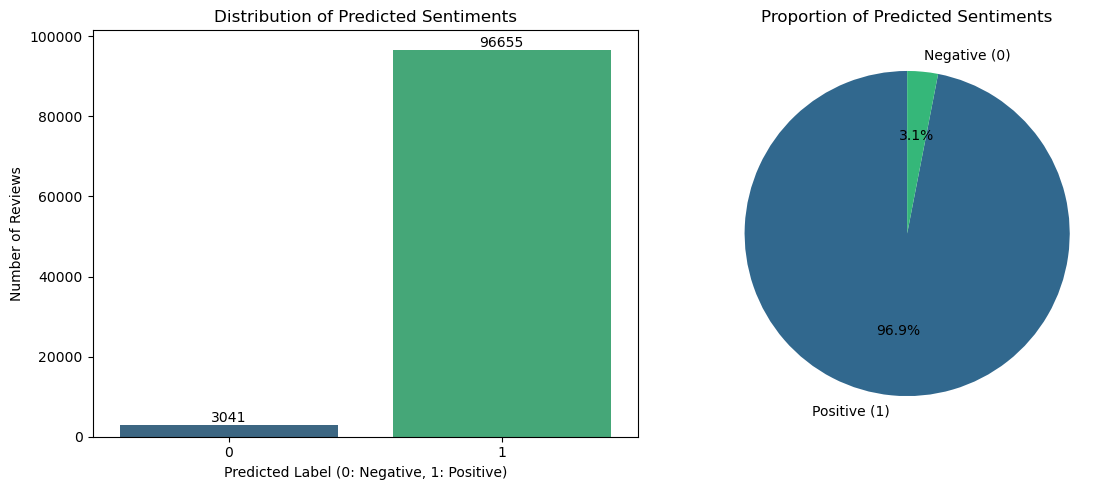

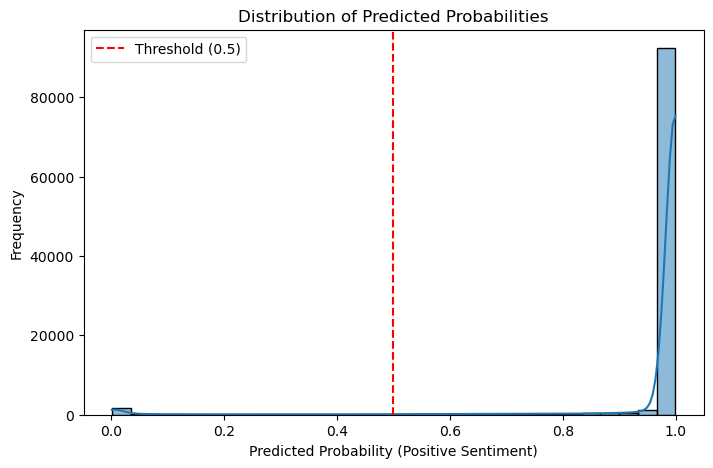

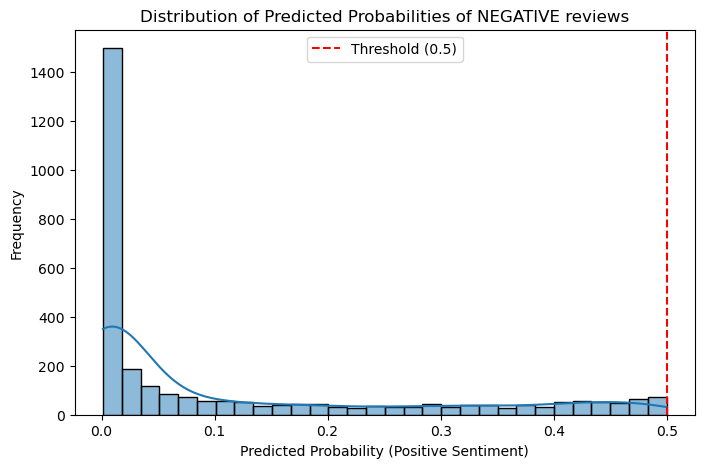

In [ ]:
# --- 12. Visualize the distribution of predictions ---
if 'predicted_label' in df_predict.columns:
    print("\nVisualizing prediction distribution...")

    plt.figure(figsize=(12, 5))

    # Count plot for predicted labels
    plt.subplot(1, 2, 1)
    ax = sns.countplot(x='predicted_label', data=df_predict, palette='viridis')
    plt.title('Distribution of Predicted Sentiments')
    plt.xlabel('Predicted Label (0: Negative, 1: Positive)')
    plt.ylabel('Number of Reviews')
    # Add counts on top of bars
    for container in ax.containers:
        ax.bar_label(container)

    # Pie chart for predicted labels
    plt.subplot(1, 2, 2)
    label_counts = df_predict['predicted_label'].value_counts()
    plt.pie(label_counts, labels=['Positive (1)', 'Negative (0)'], autopct='%1.1f%%', startangle=90, colors=sns.color_palette('viridis', len(label_counts)))
    plt.title('Proportion of Predicted Sentiments')

    plt.tight_layout()
    plt.show()

    # Distribution of prediction probabilities
    plt.figure(figsize=(8, 5))
    sns.histplot(df_predict['predicted_probability'], bins=30, kde=True)
    plt.title('Distribution of Predicted Probabilities')
    plt.xlabel('Predicted Probability (Positive Sentiment)')
    plt.ylabel('Frequency')
    plt.axvline(threshold, color='r', linestyle='--', label=f'Threshold ({threshold})')
    plt.legend()
    plt.show()


    # Distribution of prediction probabilities
    plt.figure(figsize=(8, 5))
    sns.histplot(df_predict[df_predict['predicted_label'] == 0]['predicted_probability'], bins=30, kde=True)
    plt.title('Distribution of Predicted Probabilities of NEGATIVE reviews')
    plt.xlabel('Predicted Probability (Positive Sentiment)')
    plt.ylabel('Frequency')
    plt.axvline(threshold, color='r', linestyle='--', label=f'Threshold ({threshold})')
    plt.legend()
    plt.show()


else:
    print("\nSkipping visualization as predictions were not generated.")